In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime
from datetime import timezone
from dateutil.tz import *
import matplotlib.dates as mdates
from datetime import timedelta
import os
from model_utils import *
#from iri2016 import timeprofile, timeprofile2

In [2]:
year = 2021
month = 2
str_month = GetMonth(month)
day = 1
current_month = '%s-%d' % (str_month, year)
directory = 'Data-%s/' % current_month
str_format = 'png'
filename1 ='jul%d%02d%02d_150km.001.hdf5' % (year,month,day)
plt.rcParams['ytick.labelsize']=15
plt.rcParams['xtick.labelsize']=15


In [3]:
file_hf5 = directory + filename1
hf = h5py.File(file_hf5, 'r')

with h5py.File(file_hf5, 'r') as f:
    g = f.visit(print)

Data
Data/Array Layout
Data/Array Layout/1D Parameters
Data/Array Layout/1D Parameters/Data Parameters
Data/Array Layout/1D Parameters/gdlatr
Data/Array Layout/1D Parameters/gdlonr
Data/Array Layout/2D Parameters
Data/Array Layout/2D Parameters/Data Parameters
Data/Array Layout/2D Parameters/dvipe1
Data/Array Layout/2D Parameters/dvipn1
Data/Array Layout/2D Parameters/gdalt
Data/Array Layout/2D Parameters/snl
Data/Array Layout/2D Parameters/vipe1
Data/Array Layout/2D Parameters/vipn1
Data/Array Layout/Layout Description
Data/Array Layout/range
Data/Array Layout/timestamps
Data/Table Layout
Metadata
Metadata/Data Parameters
Metadata/Experiment Notes
Metadata/Experiment Parameters


In [4]:
def GetMatrix(directory, filename, PlotFlag, plot_format):
    ##########################################################
    ## 2020-06-16: Se verificó que la función trabaja
    ## correctamente. Se creara una nueva para hacer pruebas 
    ## con las dimensiones
    ##########################################################
    file_hf5 = directory + filename
    hf = h5py.File(file_hf5, 'r')
    #with h5py.File(file_hf5, 'r') as f:
    #    g = f.visit(print)
    days = np.array(hf['Data/Table Layout/']['day'],dtype=int)
    year = np.array(hf['Data/Table Layout/']['year'],dtype=int)
    month = np.array(hf['Data/Table Layout/']['month'],dtype=int)
    hour = np.array(hf['Data/Table Layout/']['hour'],dtype=int)
    minutes = np.array( hf['Data/Table Layout/']['min'],dtype=int)
    seconds = np.array(hf['Data/Table Layout/']['sec'],dtype=int)
    rango = hf['Data/Table Layout/']['gdalt']
    rango2D = hf['Data/Array Layout/']['range']
    #Data/Array Layout/timestamps
    timestamps = hf['Data/Array Layout/']['timestamps']
    snl =  hf['Data/Table Layout/']['snl']
    snl2 = hf['Data/Array Layout/2D Parameters/snl']
      
    vipe1 = hf['Data/Array Layout/2D Parameters/vipe1'] 
    vipn1 = hf['Data/Array Layout/2D Parameters/vipn1']
    v_zonal = np.array(vipe1)
    v_vertical = np.array(vipn1)
    snl2 = np.array(snl2)
    time_vector = []
    date_list = [] # list for datetime objects
    datetimeFormat = '%Y-%m-%d %H:%M:%S'
    for y, m, d,h, mmins, sec in zip(year,month,days,hour,minutes,seconds):
        date_string = '%d-%02d-%02d %02d:%02d:%02d' % (y,m,d,h,mmins,sec)
        date = datetime.datetime(y,m,d,h,mmins, sec)#, datetimeFormat)
        time_vector.append(date_string)
        date_list.append(date)
    #####################################################################
    index = pd.DatetimeIndex(date_list) - timedelta(hours=5)
     ##########################################################
    # Aquí viene la conversión a listas 
    #converted_value = getattr(value, "tolist", lambda: value)()
    days = getattr(days, "tolist", lambda: days)()
    year = getattr(year, "tolist", lambda: year)()
    month = getattr(month, "tolist", lambda: month)()
    hour = getattr(hour, "tolist", lambda: hour)()
    minutes = getattr(minutes, "tolist", lambda: minutes)()
    seconds = getattr(seconds, "tolist", lambda: seconds)()
    rango = getattr(rango, "tolist", lambda: rango)()
    ###########################################################
    ran_max = max(rango)
    ran_min = min(rango)
    #rang_list = list(rango)
    max_index = rango.index(ran_max)
    min_index = rango.index(ran_min)
    range_diff = np.diff(rango)
    delta_range = range_diff[0] #valor constante para todo el arreglo
    MinRange, MaxRange = np.min(rango), ran_max#np.max(rango)
    DataMatrixRows = int((MaxRange-MinRange)/delta_range)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    DataMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    RowInMatrix = np.array((rango-MinRange)/delta_range, dtype=int)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    RangeMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    #DataMatrix_v_zonal = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    #DataMatrix_v_vertical = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    
    string_date = index[0].strftime('%B %d, %Y, %r')
    #line.split()[0]
    #mes = string_date.split()[0]
    month_prime = index[0].month
    #if mes == 'June':
    #    mes ='Junio'
    #if mes == 'July':
    #    mes = 'Julio'
    #if mes == 'August':
    #    mes ='Agosto'
    mes = GetMonth(month_prime)
    dia = index[0].day
    anio = index[0].year
    
    dir_plots = 'Plots-150km-%s-%d' % (mes, anio)
    col = 0 #counter for current columns
    PastRow = 0 #saving past row index
    #print("range(rango.size) ",range(rango.size))
    for k in range(len(rango)):
        row = RowInMatrix[k] 
    # Putting snr in corresponding matrix element
        DataMatrix[row,col] = snl[k]
        if row<PastRow:
            col += 1
        PastRow = row
    data = DataMatrix#[::-1]
    
    #######################################################################################################
    if (PlotFlag):
        fig, ax = plt.subplots(figsize=(12, 6))
        #plt.rcParams['xtick.labelsize']=14
        
        #plt.style.use('dark_background')
        x_min = mdates.date2num(np.min(index))
        x_max = mdates.date2num(np.max(index))
        extent=[x_min, x_max,ran_min,ran_max]
        im2 = plt.imshow(data, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb2 = fig.colorbar(im2)
        cb2.set_label(r'$log_{10}SNR$', fontsize=17)
        #plt.savefig(r'ESF-no-labels-%d-%02d-%02d.png' % (year[0], month[0], days[0]))
        plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)
    #####################################################################################
        fig, ax = plt.subplots(figsize=(12, 6))
        #plt.rcParams['xtick.labelsize']=14
        #plt.style.use('dark_background')
        im3 = plt.imshow(v_vertical.T, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)

        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb3 = fig.colorbar(im3)
        cb3.set_label(r'Velocidad vertical (m/s)', fontsize=15)
        #plt.savefig(r'ESF-no-labels-%d-%02d-%02d.png' % (year[0], month[0], days[0]))
        plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-v-vertical.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)   
    #####################################################################################
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.style.use('dark_background')
        #plt.rcParams['xtick.labelsize']=14
        im4 = plt.imshow(v_zonal.T, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb4 = fig.colorbar(im4)
        cb4.set_label(r'Velocidad zonal (m/s)', fontsize=15)
        #plt.savefig(r'ESF-no-labels-%d-%02d-%02d.png' % (year[0], month[0], days[0]))
        plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-v-zonal.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)   
    
    return  data ,snl, index, range_array, rango, dir_plots, time_vector, v_zonal, v_vertical, rango2D, timestamps, snl2

In [5]:
datetime_str = '2021-02-01 13:55:26'
datetime_object = datetime.datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')



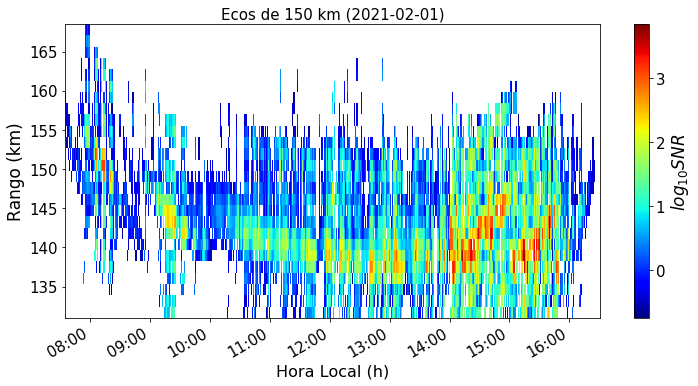

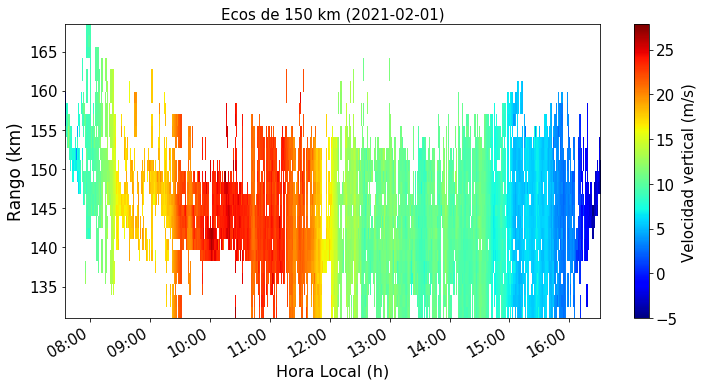

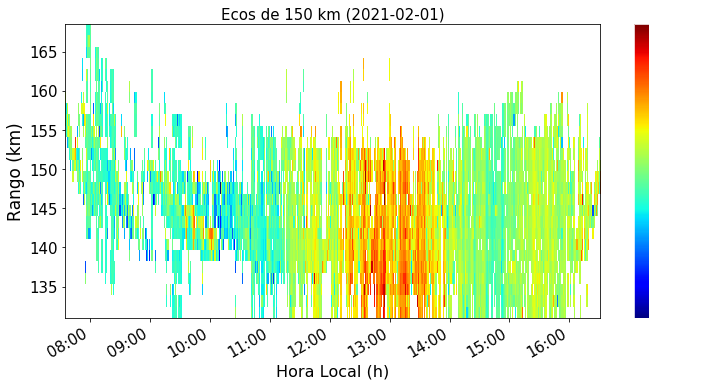

(26, 502) 5742 (5742,) (26,) 5742
Timestamps,rango2D, vertical:  (502,) (26,) (502, 26)
<class 'numpy.ndarray'>
1.5


In [6]:
PlotFlag = True
data ,snl, day_index, range_array, rango, dir_plots, time_vector, v_zonal, v_vertical, rango2D, timestamps, snl2 = GetMatrix(directory, filename1, PlotFlag, 'png')
print(data.shape, len(snl), day_index.shape, range_array.shape, len(rango))
print("Timestamps,rango2D, vertical: ", timestamps.shape, rango2D.shape, v_vertical.shape)
print(type(v_vertical.T))
delta_ran = np.diff(range_array)[0]
print(delta_ran)

In [7]:
#print(timestamps[0])
str_t0 = '%d-%02d-%02d 09:00:00' % (year,day_index[0].month, day_index[0].day)
str_tf = '%d-%02d-%02d 17:00:00' % (year,day_index[0].month, day_index[0].day)

t0 = datetime.datetime.strptime(str_t0, '%Y-%m-%d %H:%M:%S')
tf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
i = 0
ind0 = 0
indf = -1
datetime_objects = [] 
for ts in timestamps:
    #datetime_objects.append(datetime.timestamp(ts))
    dt = datetime.datetime.fromtimestamp(ts)
    datetime_objects.append(dt)
    if (dt >= t0):
        #print('9 AM!', i)
        ind0=i
        continue
    if (dt >= tf):
        #print('5 PM!')
        indf=i
    i = i + 1
    
    #if indf == 0:
    #    inf
print("índices iniciales y finales:", ind0, indf)
print(datetime_objects[-1])
print(datetime_objects[ind0])

índices iniciales y finales: 53 -1
2021-02-01 16:28:13
2021-02-01 09:00:28


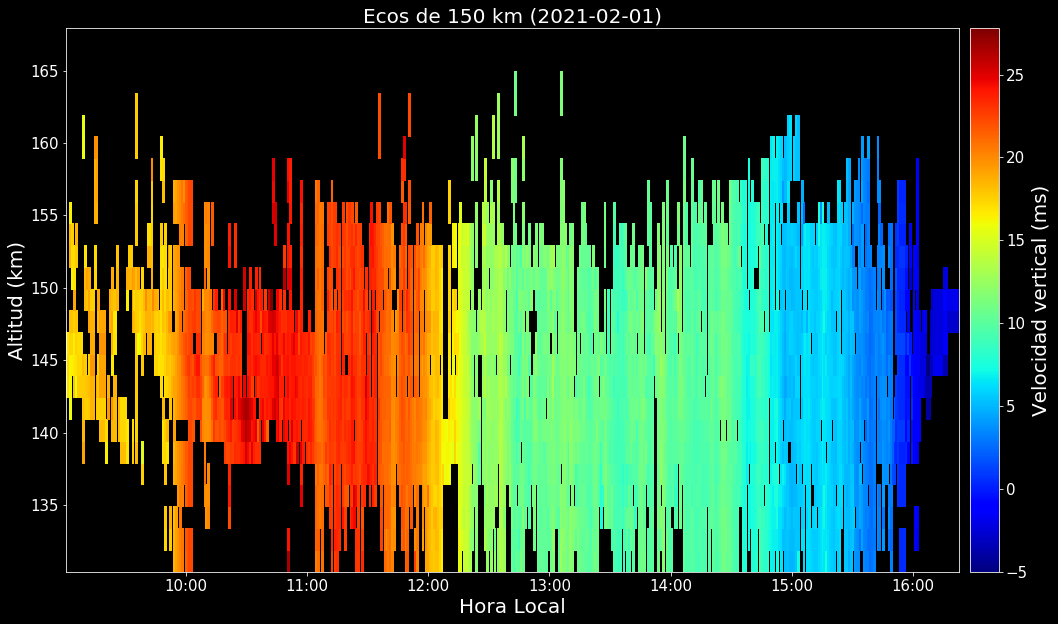

In [8]:
#fig,ax=plt.subplots(1,1)
fig, ax = plt.subplots(figsize=(16, 10))
#plt.rcParams['xtick.labelsize']=14
        
#plt.style.use('dark_background')
#clrs = ax.pcolormesh(mdates.date2num(bdat['time']),bdat['altitude'],bdat['ne'],vmin=0,vmax=2e11)
#clrs = ax.pcolormesh(datetime_objects,rango2D,v_vertical.T, cmap='jet')#,vmin=0,vmax=2e11)
clrs = ax.pcolormesh(datetime_objects[ind0:indf],rango2D,v_vertical.T[:,ind0:indf], cmap='jet')#,vmin=0,vmax=2e11)

#ax.set_ylim([100,400])
fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (day_index[0].year, day_index[0].month, day_index.day[0]) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('Hora Local', fontsize=20)
ax.set_ylabel('Altitud (km)', fontsize=20)
ax.set_title(fig_title, fontsize=20)

box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.set_label('Velocidad vertical (ms)', fontsize=20)
plt.savefig('new-plots-vertical-drift-%d-%02d-%02d.png' % (day_index[0].year, day_index[0].month, day_index.day[0]))

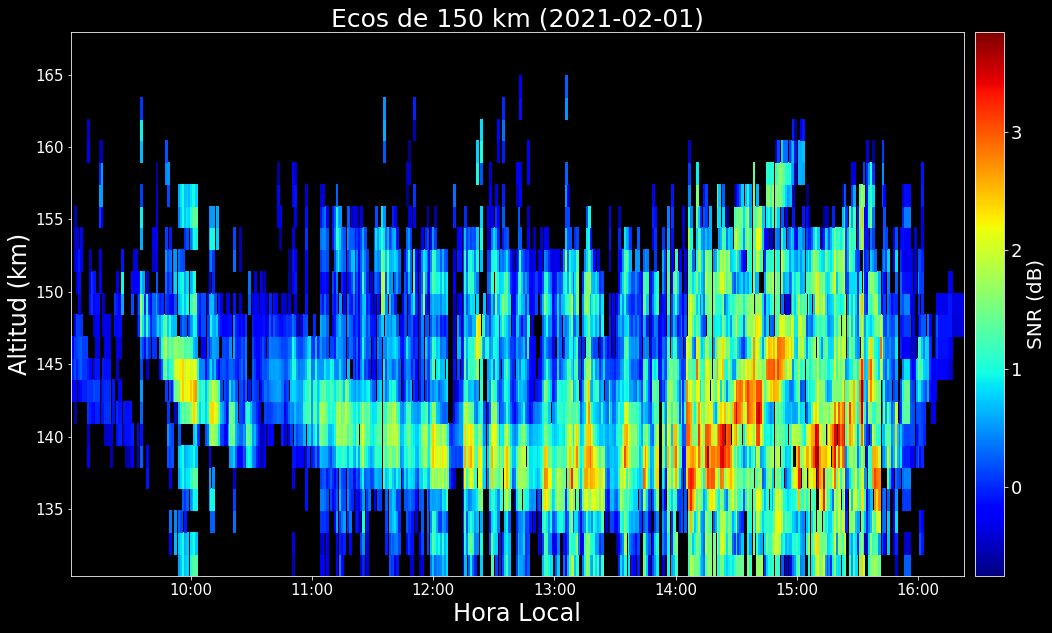

In [9]:
#fig,ax=plt.subplots(1,1)
fig, ax = plt.subplots(figsize=(16, 10))
#plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=18
plt.rcParams['xtick.labelsize']=18       
#plt.style.use('dark_background')
#clrs = ax.pcolormesh(mdates.date2num(bdat['time']),bdat['altitude'],bdat['ne'],vmin=0,vmax=2e11)
#clrs = ax.pcolormesh(datetime_objects,rango2D,v_vertical.T, cmap='jet')#,vmin=0,vmax=2e11)
clrs = ax.pcolormesh(datetime_objects[ind0:indf],rango2D,snl2.T[:,ind0:indf], cmap='jet')#,vmin=0,vmax=2e11)

#ax.set_ylim([100,400])
fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (day_index[0].year, day_index[0].month, day_index.day[0]) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('Hora Local', fontsize=24)
ax.set_ylabel('Altitud (km)', fontsize=24)
ax.set_title(fig_title, fontsize=25)

box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.set_label('SNR (dB)', fontsize=20)
plt.savefig('new-plots-snr-vertical-drift-%d-%02d-%02d.pdf' % (day_index[0].year, day_index[0].month, day_index.day[0]))

In [10]:
prev_times = [' ']
k = 0
for time in day_index:
    if prev_times[k] == time:
           print('Same Time')
    else:
        #print 'Different time'
        if not time in prev_times:
            prev_times.append(time)
        prev_time = time


prev_times = prev_times[1:]
num_diff_times = len(prev_times)
print(num_diff_times)

502


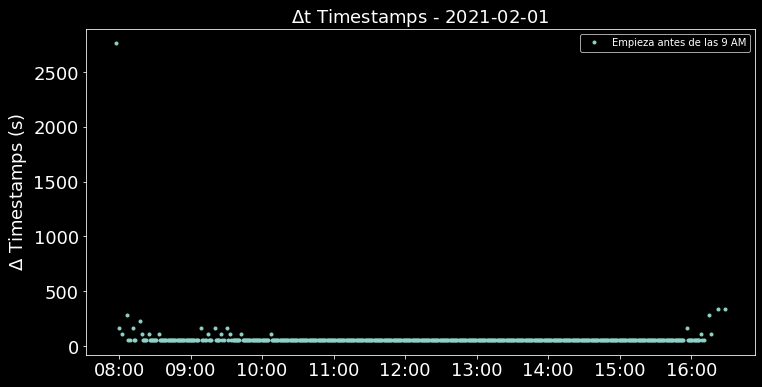

In [11]:
diff1 = np.diff(datetime_objects[ind0:])
diff2 = np.diff(datetime_objects)

secs1 = []
secs2 = []
for d1 in diff1:
    secs1.append(d1.seconds)
for d2 in diff2:
    secs2.append(d2.seconds)

#plt.hist(secs)
fig, axs = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
#plt.plot(datetime_objects[1:],secs2, label='Empieza antes de las 9 AM')
plt.plot(datetime_objects[1:],secs2, '.',label='Empieza antes de las 9 AM')

#plt.plot(secs1, label='> 9 AM')
fig_title = r'$\Delta$t Timestamps - %d-%02d-%02d' % (day_index[0].year, day_index[0].month, day_index[0].day) 
axs.set_title(fig_title, fontsize=18)
#axs.set_facecolor("white")

axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#axs.set_xlabel('Hora Local', fontsize=18)
axs.set_ylabel(r'$\Delta$ Timestamps (s)', fontsize=18)
#axs.set_xlim([10
plt.legend()
plt.savefig('delta-timestamps-vs-tiempo-%d-%02d-%02d.%s' % (day_index[0].year, day_index[0].month, day_index[0].day, str_format))

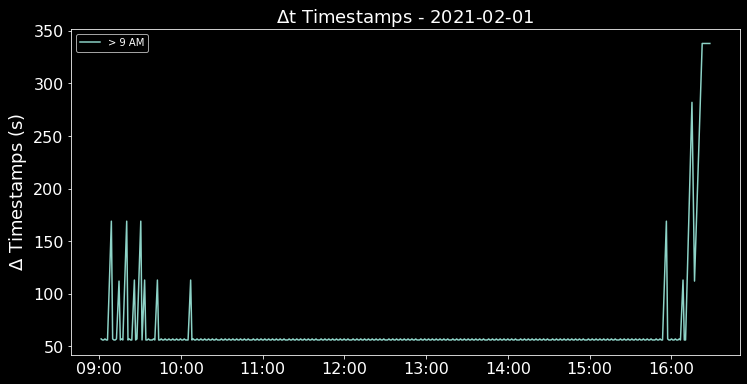

In [12]:
fig, axs = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
plt.plot(datetime_objects[ind0+1:],secs1, label='> 9 AM')
fig_title = "Número de Timestamps - Agosto 2020"
axs.set_title(fig_title, fontsize=18)
#axs.set_facecolor("white")

fig_title = r'$\Delta$t Timestamps - %d-%02d-%02d' % (day_index[0].year, day_index[0].month, day_index[0].day) 
axs.set_title(fig_title, fontsize=18)
#axs.set_facecolor("white")

axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#axs.set_xlabel('Hora Local', fontsize=18)
axs.set_ylabel(r'$\Delta$ Timestamps (s)', fontsize=18)
#axs.set_xlim([10
plt.legend()
plt.savefig('nueve-delta-timestamps-vs-tiempo-%d-%02d-%02d.%s' % (day_index[0].year, day_index[0].month, day_index[0].day, str_format))

In [13]:
print(len(secs1), diff2.shape)

448 (501,)


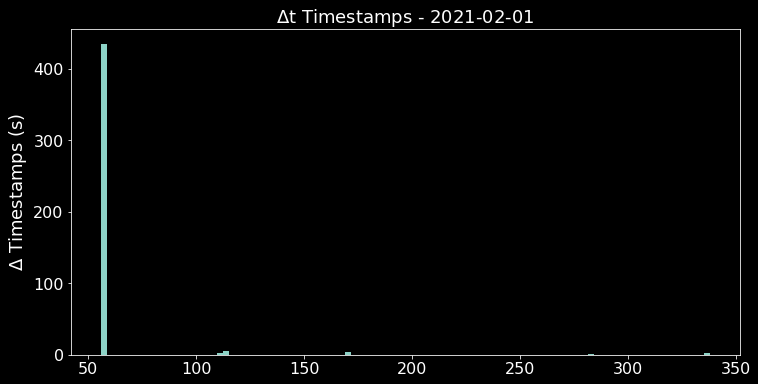

In [14]:
fig, axs = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
plt.hist(secs1, bins=100)#, label='> 9 AM')
fig_title = "Número de Timestamps - Agosto 2020"
axs.set_title(fig_title, fontsize=18)
#axs.set_facecolor("white")

fig_title = r'$\Delta$t Timestamps - %d-%02d-%02d' % (day_index[0].year, day_index[0].month, day_index[0].day) 
axs.set_title(fig_title, fontsize=18)
#axs.set_facecolor("white")

#axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#axs.set_xlabel('Hora Local', fontsize=18)
axs.set_ylabel(r'$\Delta$ Timestamps (s)', fontsize=18)
#axs.set_xlim([10
#plt.legend()
plt.savefig('delta-timestamps-histogram-%d-%02d-%02d.%s' % (day_index[0].year, day_index[0].month, day_index[0].day, str_format))


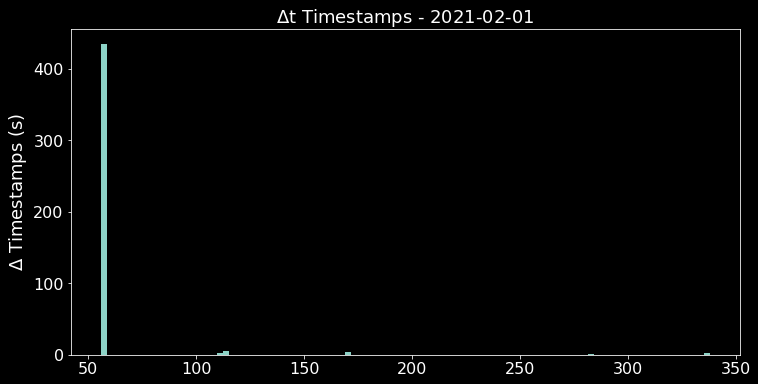

In [15]:
fig, axs = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
plt.hist(secs1, bins=100)#, label='> 9 AM')
fig_title = "Número de Timestamps - Agosto 2020"
axs.set_title(fig_title, fontsize=18)
#axs.set_facecolor("white")

fig_title = r'$\Delta$t Timestamps - %d-%02d-%02d' % (day_index[0].year, day_index[0].month, day_index[0].day) 
axs.set_title(fig_title, fontsize=18)
#axs.set_facecolor("white")

#axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#axs.set_xlabel('Hora Local', fontsize=18)
axs.set_ylabel(r'$\Delta$ Timestamps (s)', fontsize=18)
#axs.set_xlim([10
#plt.legend()
plt.savefig('delta-timestamps-histogram-%d-%02d-%02d.%s' % (day_index[0].year, day_index[0].month, day_index[0].day, str_format))

### Monthly stuff

In [16]:
#'''
PlotFlag = False
plot_format= 'png'
h_min = []
h_max = []
frames_avg = []
frames_std = []
num_stamps = []
t_h_min = []
t_h_max = []
for filename in os.listdir(directory):
    if filename.endswith(".hdf5"):
        #print(os.path.join(directory, filename))
        data ,snl, index, range_array, rango, dir_plots, time_vector, v_zonal, v_vertical, rango2D, timestamps, snl2 = GetMatrix(directory, filename, PlotFlag, plot_format)
        #print(data.shape, len(snl), index.shape, range_array.shape, len(rango))
        print(data.shape, index[0],index[-1], (index[1]-index[0]).total_seconds() ,range_array[0], range_array[-1], np.diff(range_array)[0]) 
        prev_times = [' ']
        k = 0
        for time in index:
            if prev_times[k] == time:
                   print('Same Time')
            else:
                #print 'Different time'
                if not time in prev_times:
                    prev_times.append(time)
                prev_time = time

        h_min.append(min(rango))
        h_max.append(max(rango))
    ###########################################################
        ran_max = max(rango)
        ran_min = min(rango)
        #rang_list = list(rango)
        max_index = rango.index(ran_max)
        min_index = rango.index(ran_min)
        t_h_min.append(index[min_index].to_pydatetime())
        t_h_max.append(index[max_index].to_pydatetime())
    ############################################################
        num_stamps.append(len(timestamps))
        prev_times = prev_times[1:]
        num_diff_times = len(prev_times)
        #print(num_diff_times)
        new_index = pd.DatetimeIndex(prev_times)
        v_vert_avg = np.nanmean(v_vertical,axis=1)
        v_vert_std = np.nanstd(v_vertical,axis=1)
        #print("Vertical Average shape: ", v_vert_avg.shape, new_index.shape, new_index[0], new_index[-1])
        v_vert_avg = np.nanmean(v_vertical,axis=1)
        v_vert_std = np.nanstd(v_vertical,axis=1)
        df_std = pd.Series(v_vert_std, index=new_index)
        df = pd.Series(v_vert_avg, index=new_index)
        #df.set_index(index, inplace=True, drop=True)
        string_t0 = '%d-%02d-%02d %02d:%02d:00' % (new_index[0].year,new_index[0].month, new_index[0].day, 9,0)
        string_tf = '%d-%02d-%02d %02d:00:00' % (new_index[0].year,new_index[0].month, new_index[0].day, 17)
        
        if PlotFlag:
            fig, ax = plt.subplots(figsize=(12, 6))
            str_date = '%d-%02d-%02d' % (new_index[0].year,new_index[0].month,new_index[0].day)
            ax = df[string_t0:string_tf].plot()
            ax.set_ylabel('(m/s)', fontsize=20)
            ax.set_title('Velocidad Vertical Promedio (m/s) %s' % str_date, fontsize=20)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))
            plt.savefig('velocidad-vertical-promedio-%s.%s' % (str_date, str_format))
            plt.show()
            plt.close(fig)
            
            fig1, ax1 = plt.subplots(figsize=(12, 6))
        #str_date = '%d-%02d-%02d' % (new_index[0].year,new_index[0].month,new_index[0].day)
        #str_format = 'png'
        #v_vert_avg = np.nanmean(v_vertical,axis=1)
        #v_vert_std = np.nanstd(v_vertical,axis=1)
            #df_std = pd.Series(v_vert_std, index=new_index)
        #df = pd.Series(v_vert_avg, index=new_index)
        #df.set_index(index, inplace=True, drop=True)
            ax1 = df_std[string_t0:string_tf].plot()
            ax1.set_ylabel('(m/s)', fontsize=20)
            ax1.set_title(r'Velocidad Vertical $\sigma$ (m/s) %s' % str_date, fontsize=20)
        #ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))
            plt.savefig('velocidad-vertical-desviacion-estandar-%s.%s' % (str_date, str_format))
            plt.show()
            plt.close(fig)
        frames_avg.append(df[string_t0:string_tf])
        frames_std.append(df_std[string_t0:string_tf])
#'''

(33, 447) 2021-02-21 07:29:40 2021-02-21 16:35:01 0.0 130.95 178.95 1.5
(33, 341) 2021-02-14 07:04:30 2021-02-14 16:55:25 0.0 130.95 178.95 1.5
(33, 482) 2021-02-18 07:06:21 2021-02-18 17:57:19 0.0 130.95 178.95 1.5
(26, 502) 2021-02-01 07:34:34 2021-02-01 16:31:02 0.0 130.95 168.45 1.5
(32, 516) 2021-02-19 07:28:59 2021-02-19 17:12:23 0.0 130.95 177.45 1.5
(33, 569) 2021-02-02 07:18:15 2021-02-02 17:05:24 0.0 130.95 178.95 1.5
(33, 318) 2021-02-13 07:31:07 2021-02-13 17:10:19 0.0 130.95 178.95 1.5
(33, 455) 2021-02-22 07:15:31 2021-02-22 16:34:02 0.0 130.95 178.95 1.5
(32, 539) 2021-02-03 07:10:50 2021-02-03 16:52:49 0.0 130.95 177.45 1.5
(33, 468) 2021-02-16 07:07:56 2021-02-16 16:37:07 0.0 130.95 178.95 1.5
(33, 543) 2021-02-09 07:07:36 2021-02-09 17:20:06 0.0 130.95 178.95 1.5
(33, 557) 2021-02-06 07:03:06 2021-02-06 17:00:05 0.0 130.95 178.95 1.5
(33, 471) 2021-02-24 07:10:06 2021-02-24 16:41:45 0.0 130.95 178.95 1.5
(33, 480) 2021-02-25 07:17:40 2021-02-25 16:42:45 0.0 130.95 178

/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/juanpablo/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice


(32, 283) 2021-02-11 07:02:04 2021-02-11 17:02:06 0.0 130.95 177.45 1.5
(33, 499) 2021-02-07 07:24:16 2021-02-07 17:59:17 0.0 130.95 178.95 1.5
(27, 198) 2021-02-28 08:55:32 2021-02-28 13:59:41 0.0 130.95 169.95 1.5
(33, 500) 2021-02-26 07:15:53 2021-02-26 16:59:45 0.0 130.95 178.95 1.5
(32, 529) 2021-02-08 07:06:30 2021-02-08 16:36:20 0.0 130.95 177.45 1.5
(33, 578) 2021-02-10 07:18:26 2021-02-10 17:20:36 0.0 130.95 178.95 1.5
(32, 501) 2021-02-17 07:06:18 2021-02-17 17:02:22 0.0 130.95 177.45 1.5
(32, 366) 2021-02-12 07:11:47 2021-02-12 17:25:40 0.0 130.95 177.45 1.5
(32, 479) 2021-02-20 07:17:50 2021-02-20 16:34:00 0.0 130.95 177.45 1.5
(33, 334) 2021-02-15 07:14:53 2021-02-15 17:03:00 0.0 130.95 178.95 1.5
(33, 554) 2021-02-04 07:08:34 2021-02-04 17:05:34 0.0 130.95 178.95 1.5
(33, 484) 2021-02-23 07:24:32 2021-02-23 16:43:59 0.0 130.95 178.95 1.5
(33, 494) 2021-02-27 07:06:08 2021-02-27 16:35:55 0.0 130.95 178.95 1.5
(32, 584) 2021-02-05 07:08:12 2021-02-05 17:09:24 0.0 130.95 177

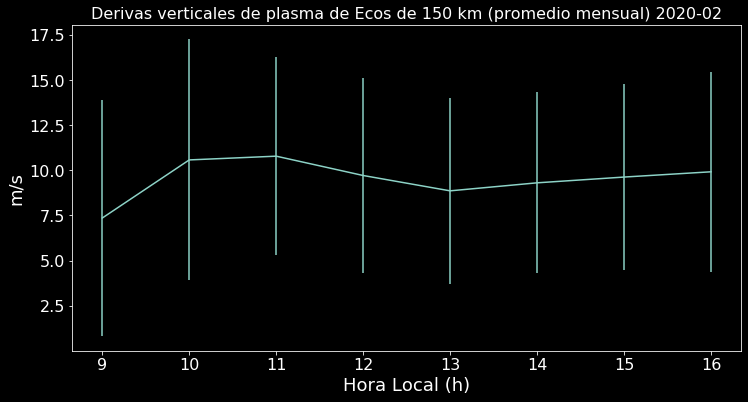

In [17]:
#'''
series_avg = pd.concat(frames_avg)
series_std = pd.concat(frames_std)
fig, axs = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
#plt.style.use('seaborn-white')#'ggplot')#'classic')
series_avg.groupby(series_avg.index.hour).mean().plot(yerr=series_avg.groupby(series_std.index.hour).std(),rot=0,ax=axs)
fig_title = 'Derivas verticales de plasma de Ecos de 150 km (promedio mensual) 2020-%02d' % (day_index[0].month)
axs.set_title(fig_title, fontsize=16)
#axs.set_facecolor("white")

#axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs.set_xlabel('Hora Local (h)', fontsize=18)
axs.set_ylabel('m/s', fontsize=18)
#axs.set_xlim([100,400])

plt.savefig('promedio-mensual-drifts-%s.png' % current_month)
#'''

In [18]:
#plt.hist(h_max)
#h_max

In [19]:
#plt.plot(h_min)
#h_min